<h2><center> CSCI - UA 9472 - Artificial Intelligence </center></h2>

<h3><center> Assignment 4: Reinforcement Learning </center></h3>

<center>Given date: December 7
</center>
<center><font color='red'>Due date: December 20/21 </font>
</center>
<center><b>Total: 20 pts </b>
</center>


<center>In this fourth assignment, we will continue our quest for the optimal agent and replace our heavy logical reasoning model with a faster implementation based on Q-learning</center>

<img src="https://github.com/acosse/Artificial-Intelligence-Fall2021/blob/main/Assignments/Assignment4/MonsterKill.png?raw=1" width="400" height="300"/>

 = = = = = = = = = = = = = = = = = = = = = \
 **Name:** Haoming(Hammond) Liu \
 **NetID:** hl3797 \
 **Date:** Dec. 20th, 2021 \
  = = = = = = = = = = = = = = = = = = = = =

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

#### Question 1. A simple moving agent (10pts)

We consider a simple environment as shown below. Our simple agent has the possibility to move West, East, North and South (except on the borders of the environment). Moreover it has two additional actions:
    
   - It can hit with its sword (which is essentially useful when facing the skeleton)
    
   - It can open the door and escape the room (useful when being in the upper rightmost cell)
   
As you can imagine, hitting while in an empty cell is a loss of energy and should be penalized. We will thus associate useless behaviors (like hitting when alone and opening non existing doors) with a negative reward of -10. Hitting the skeleton and opening the door _when the skeleton has been killed_ should be associated with higher rewards of +30. Escaping without the kill will be associated with a negative reward of -10 (The agent should not exit before getting rid of all the evil in the room)

There are a total of 48 cells. Each cell can contain the skeleton, be empty or contain the door (exclusively) which makes a total of $48\times3 = 144$ states for your environment. Moreover, we want to keep track of whether or not the skeleton has been killed so we will take into account an additional variable encoding whether the kill has been completed. This thus leads to a total of $48\times 3\times2 = 288$.

Any move will be associated with a small penalty of -1 point    

<img src="https://github.com/acosse/Artificial-Intelligence-Fall2021/blob/main/Assignments/Assignment4/mazeAssignment3a.png?raw=1" width="400" height="300"/>


Start by coding a simple TD Q-learning agent which stores the Q-table entirely as a $288\times 6$ numpy array. Use an exploration function to avoid being stuck in a limited region of the environment. Recall that such a function can be defined as 

\begin{align}
f(Q_\theta[s,a], N[s,a]) = \left\{\begin{array}{ll}
R^+& \text{if $N[s,a]<N_e$}\\
Q_\theta[s,a]&\text{otherwise}
\end{array}\right. 
\end{align}

where $R^+$ is an estimate of the best possible reward that can be obtained in any state.

Concretely for each new state and action, you should update the $Q$-table after incrementing the count $N[s,a]$ (of the number of times action $a$ has been taken in state $s$) 

\begin{align}
Q[s, a] & \leftarrow Q[s,a] +\eta \left(N_{sa}[s,a]\right)\left(r+\gamma \max_{a'} Q[s',a'] - Q[s,a]\right)\\
s,a,r &\leftarrow s', \underset{a'}{\operatorname{argmax}} f\left(Q[s',a'], N[s',a']\right), r'
\end{align}

\eta \left(N_{sa}[s,a]\right) is a learning rate that can be set to a sufficiently small constant or be evolving as the inverse of $N[s, a]$ 

Consider a couple of episodes to make sure that you fill out a sufficient number of entries in the table. Interlace the learning phases with a couple of evaluation phases during which you should store the number of steps needed to complete the kill and exit so that you will be able to plot the evolution of your agent at the end of the simulation. 

You can associate a negative reward with the impossible actions corresponding to hitting walls on the borders of the environment.

In [2]:

# init params
Ne = 3
door_pos = (7, 5)
skeleton_pos = (3, 3)

# exploration function
exp_func = lambda n, q: float('inf') if n < Ne else q

# step to the next state
def step(s, a, bound_punish=-2):

    # init rewards, action, and states
    rewards = -1
    x, y, cell, skeleton = idx_to_state[s]

    # assign rewards and new states
    if actions[a] == 'left':
        if x == 0: rewards += bound_punish
        else: x -= 1
    if actions[a] == 'right':
        if x == 7: rewards += bound_punish
        else: x += 1
    if actions[a] == 'up':
        if y == 5: rewards += bound_punish
        else: y += 1
    if actions[a] == 'down':
        if y == 0: rewards += bound_punish
        else: y -= 1
    if actions[a] == 'hit':
        if (x, y) == skeleton_pos and skeleton:
            skeleton, rewards = False, 30
        else:
            rewards -= 10
    if actions[a] == 'leave':
        if (x, y) == door_pos and not skeleton:
            return 'exit', 30
        else:
            rewards -= 10
    
    # check state of new cell
    cell = 'nothing'
    if (x, y) == door_pos:
        cell = 'door'
    if (x, y) == skeleton_pos:
        cell = 'skeleton'

    return state_to_idx[x, y, cell, skeleton], rewards

# test the 'step' function
def test_step(state, action):
    a = actions.index(action)
    s, r = step(state_to_idx[state], a)
    print('\nTest Step:', action, 'at', state)
    if s == 'exit':
        print('game end!')
        return
    print('result:', idx_to_state[s], 'with reward', r)

# map states to index [0, 287]
idx = 0
idx_to_state = []
state_to_idx = {}
actions = ['left', 'right', 'up', 'down', 'hit', 'leave']
cell_types = ['nothing', 'skeleton', 'door']
for i in range(8):
    for j in range(6):
        for k in cell_types:
            idx_to_state.append((i, j, k, True))
            idx_to_state.append((i, j, k, False))
            state_to_idx[i, j, k, True] = idx
            state_to_idx[i, j, k, False] = idx + 1
            idx += 2

# test printing
print(idx_to_state)
print(state_to_idx)
test_step((0, 0, 'nothing', True), 'left')
test_step((3, 3, 'skeleton', True), 'hit')
test_step((7, 5, 'door', False), 'leave')

[(0, 0, 'nothing', True), (0, 0, 'nothing', False), (0, 0, 'skeleton', True), (0, 0, 'skeleton', False), (0, 0, 'door', True), (0, 0, 'door', False), (0, 1, 'nothing', True), (0, 1, 'nothing', False), (0, 1, 'skeleton', True), (0, 1, 'skeleton', False), (0, 1, 'door', True), (0, 1, 'door', False), (0, 2, 'nothing', True), (0, 2, 'nothing', False), (0, 2, 'skeleton', True), (0, 2, 'skeleton', False), (0, 2, 'door', True), (0, 2, 'door', False), (0, 3, 'nothing', True), (0, 3, 'nothing', False), (0, 3, 'skeleton', True), (0, 3, 'skeleton', False), (0, 3, 'door', True), (0, 3, 'door', False), (0, 4, 'nothing', True), (0, 4, 'nothing', False), (0, 4, 'skeleton', True), (0, 4, 'skeleton', False), (0, 4, 'door', True), (0, 4, 'door', False), (0, 5, 'nothing', True), (0, 5, 'nothing', False), (0, 5, 'skeleton', True), (0, 5, 'skeleton', False), (0, 5, 'door', True), (0, 5, 'door', False), (1, 0, 'nothing', True), (1, 0, 'nothing', False), (1, 0, 'skeleton', True), (1, 0, 'skeleton', False), (

In [3]:
# part 1: TD Q-learning agent

# init params
gamma = 0.1
N = np.zeros((288, 6))
Q = np.zeros((288, 6))

num_evaluations = 10
time_to_completion = np.zeros((num_evaluations,))

for k in np.arange(num_evaluations):
    for episode in np.arange(200):
        s = 0   # state with idx 0 is the starting state
        while True:
            # take a step, and exit if the game is over
            a = np.argmax([exp_func(N[s, i], Q[s, i]) for i in range(6)])
            sp, r = step(s, a)
            if sp == 'exit':
                break
            # lr function from lecture slides
            lr = 60 / (N[s, a] + 60)
            # TD update
            td = r + gamma * np.max(Q[sp]) - Q[s, a]
            Q[s, a] += lr * td
            # update frequency (exploration function)
            N[s, a] += 1
            # update state
            s = sp
        # print('ep %02d' % episode)

    # evaluate the agent   
    s = 0
    step_count = 0
    while True:
        a = np.argmax([exp_func(N[s, i], Q[s, i]) for i in range(6)])
        s, r = step(s, a)
        step_count += 1
        if s == 'exit':
            break
    
    time_to_completion[k] = step_count
    print('eval %02d:' % (k+1), step_count)

eval 01: 14
eval 02: 14
eval 03: 14
eval 04: 14
eval 05: 14
eval 06: 14
eval 07: 14
eval 08: 14
eval 09: 14
eval 10: 14


Text(0, 0.5, 'total steps')

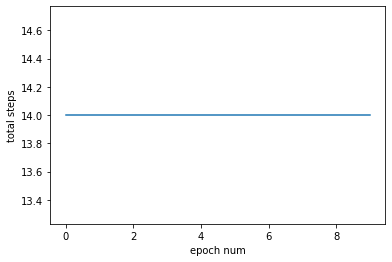

In [4]:
# plot eval steps for each epoch
plt.plot(time_to_completion)
plt.xlabel('epoch num')
plt.ylabel('total steps')

#### Question 2. The parametric model (15pts)

We now want to improve the generalization skills of our agent. We will encode our $Q$-table as a simple feedforward neural network. To avoid losing time with the implementation, we will rely on keras for the architecture (see below). We will consider a simple one hidden layer network that takes as input a vector encoding the current state of the environment (note that such a vector can be encoded in various ways, for example as a $5$-tuple including the cartesian coordinates of the agent and 3 variables indicating whether there is a door, skeleton,..) and returns as ouput the value associated with each of the actions. In other words we consider a parametric model $f_\theta\in \mathbb{R}^{|a|}$ such that $[f_{\theta}(s)]_a \approx Q[s, a]$. Recall that the TD update for such a model is given

\begin{align}
\theta_i &\leftarrow \theta_i + \alpha \left[R[s] + \gamma \max_{a'} \hat{Q}_{\theta}[s',a'] - \hat{Q}[s,a]\right]\frac{\partial \hat{Q}_\theta[s,a]}{\partial \theta_i} 
\end{align}

- Start by updating the weights after each new step (in an SGD fashion) and evaluate the agent as before by interlacing your training with a couple of evaluation step where you should compute the time needed to exit with the kill completed. 


- We will then be a little wiser and keep track of a short memory before updating the network. 

Consider the following steps :

   - Initialize the memory to an empty vector
   
    
   - As before, we will consider a number of episodes. For each episode, we will consider a full simulation (until exiting with the kill). Again you should rely on some exploration function to alternate between exploration and exploitation (selection of the action corresponding to the maximum output of the network for the current state). 
   
    
   - After each action, observe the reward and store the tuple $(s_t, a_t, r_t, s_{t+1})$ and store it in the memory. 
   
    
   - Select a random minibatch from the memory and update the networks through a gradient update on the minibatch (mb) 
    
    $$\min_{\theta_i} \frac{1}{\text{size}(\text{mb})}\sum_{t\in \text{mb}}\left(R[s_t] + \gamma \max_{a_{t+1}} \hat{Q}_{\theta}[s_{t+1},a_{t+1}] - \hat{Q}_\theta[s_t,a_t]\right)^2 $$



- To see how to build a Feedforward neural network in keras, the simplest approach is to use the method 'add' such as in

        model = keras.Sequential()
        model.add(layers.Dense(n, activation="relu"))

    you can see [here](https://keras.io/guides/sequential_model/) for more details.
    
    
    
- Once you have built the model, you need to select an optimizer before you can train it. This can be implemented through the ['compile method'](https://keras.io/api/optimizers/)

          model.compile(optimizer='SGD',
          loss='mean_squared_error',
          metrics=['accuracy'])
          
- Finally to train the network, you can rely on the fit function (see also [here](https://keras.io/api/models/model_training_apis/))

        model.fit(train_data, train_labels,epochs=5)
        
Note that Keras (when using 'compile' with the SGD option) relies on a default batch of size 32 so either you should specify a smaller batch size or you should make sure your memory is sufficiently big. Also note that as written above we will in fact do a coule of SGD iterations (one for each sample in the minibatch, repeated epochs times).  

In [5]:
# convert a state idx to an embedding vector of size (1, 6)
# Note: for flags, True => 100, False => 1
def state_embedding(s, true_flag=100):
    x, y, cell, skeleton = idx_to_state[s]
    kill_flag = true_flag if not skeleton else 0
    door_flag = true_flag if cell == 'door' else 0
    cell_flag = true_flag if cell == 'nothing' else 0
    skeleton_flag = true_flag if cell == 'skeleton' else 0
    return np.array(
        [x, y, kill_flag, door_flag, cell_flag, skeleton_flag]
    ).reshape(1, 6)

# convert the recoreds in buffer to (data, labels)
def convert(buffer, model, mode='q-table', gamma=0.1):
    data_list = []
    label_list = []
    for s, a, r, sp in buffer:
        if mode == 'q-table':
            label = Q[s, :].reshape(1, 6)
            s = state_embedding(s)
        else:
            # follow the question, use (r[s] + gamma * max(Q[s', a']))
            # Note: this is relatively slow
            s, sp = state_embedding(s), state_embedding(sp)
            label = model.predict(s)
            label[0, a] = r + gamma * np.max(model.predict(sp))
        data_list.append(s)
        label_list.append(label)
    return np.vstack(data_list), np.vstack(label_list)

# init model
def get_model(linear=False, hidden=32, act='relu'):
    if linear:
        return Sequential([
            keras.Input(shape=(6,)),
            Dense(6) 
        ])
    assert isinstance(hidden, int)
    return Sequential([
        keras.Input(shape=(6,)),
        Dense(hidden, activation=act),
        Dense(6) 
    ])

# init optimizer
def get_optim(optimizer, lr=0.01):
    assert optimizer in ('SGD', 'Adam')
    if optimizer == 'SGD':
        return keras.optimizers.SGD(learning_rate=lr)
    else:
        return keras.optimizers.Adam(learning_rate=lr)

# test functions
optim = get_optim('SGD', lr=0.1)
model = get_model(linear=True)
model.compile(
    optimizer=optim,
    loss='mean_squared_error',
    metrics=['accuracy']
)
print('test embedding:', state_embedding(123), sep='\n')
buffer = [(0, 0, 100, 2), (287, 5, -100, 2)]
print('test pred:', *convert(buffer, model), sep='\n')

test embedding:
[[  3   2 100   0   0 100]]
test pred:
[[  0   0   0   0 100   0]
 [  7   5 100 100   0   0]]
[[ -3.          -1.11108011  -1.11108011  -3.         -11.
  -11.09994712]
 [ -1.          -3.          -3.          -1.         -11.
    0.        ]]


In [6]:
# we may use the Q-table from part 1 to train the network
assert Q is not None

door_pos = (7, 5)
skeleton_pos = (3, 3)
N = np.zeros((288, 6))

def train(config, epoch=10, episode=200, max_iter=1000):
    optim = get_optim(**config['optim_kwargs'])
    model = get_model(**config['model_kwargs'])
    model.compile(
        optimizer=optim,
        loss='mean_squared_error',
        metrics=['accuracy']
    )
    # print(model.summary())

    for k in range(epoch):
        for e in range(episode):
            s = 0
            buffer = []
            while True:
                if config['action_selection'] == 'q-table':
                    # generate training samples based on part 1
                    a = np.argmax([Q[s, i] for i in range(6)])
                else:
                    # generate training samples from scratch
                    # Note: this is really slow
                    A = model.predict(state_embedding(s))
                    a = np.argmax([exp_func(N[s, i], A[0, i]) for i in range(6)])
                # take s step, exit as needed
                sp, r = step(s, a)
                if sp == 'exit':
                    break
                # recard the sample
                buffer.append((s, a, r, sp))
                N[s, a] += 1
                # update state
                s = sp
            # fit the model using the sample
            # Note: keras split the data to batches automatically
            data, labels = convert(buffer, model, mode=config['label_mode'])
            model.fit(data, labels, epochs=5, verbose=config['verbose'])
            print('\r epoch %02d, ep %02d.' % (k+1, e+1), end='')

        if config['test_pred']:
            print('\ntest pred:')
            print(model.predict(state_embedding(0)))

        # evaluate the agent
        # Note: it seems that the agent cannot exit in all cases
        s = 0
        step_count = 0
        while True:
            A = model.predict(state_embedding(s))
            a = np.argmax([exp_func(N[s, i], A[0, i]) for i in range(6)])
            s, r = step(s, a)
            step_count += 1
            if (s == 'exit') or (step_count > max_iter):
                break
        if step_count > max_iter:
            print('max iter reached, eval fail.\n')
            time_to_completion[k] = 1000
            # break
        else:
            time_to_completion[k] = step_count
            print('eval %02d:' % (k+1), step_count)

#### Question 3. (5pts) 

Compare and plot the improvement in the behavior of your agent for a couple of neural networks architectures. Don't make the network overly complicated. You can just try different activation functions with different numbers of units per layers (possibly also consider a _small_ number of hidden layers)

In [7]:
"""
setting that follows the question instruction
    1) SGD optimizer (lr = 0.01)
    2) 2-layer MLP, with 32 hidden units, relu activation
    3) action selection: argmax(exp_func(N[s, i], A[0, i])), 0 <= i <= 5
    4) true label: r[s] + gamma * max(Q[s', a'])

Note: This is extremely slow, please skip this cell while running.
"""

# config = {
#     'optim_kwargs': {'optimizer': 'SGD', 'lr': 0.01},
#     'model_kwargs': {'linear': False, 'hidden': 32, 'act': 'relu'},
#     'action_selection': 'TD',
#     'label_mode': 'TD',
#     'test_pred': False,
#     'verbose': False
# }

# train(config)

print('skip this cell')

skip this cell


In [12]:
"""
setting that follows the question instruction
    1) Adam optimizer (lr = 0.01)
    2) 2-layer MLP, with 32 hidden units, relu activation
    3) action selection: q-table from part 1
    4) true label: r[s] + gamma * max(Q[s', a'])

Note: 1) A bit faster, but still cannot exit.
      2) Num of episode is quite small (only for a demonstration of speed).
"""

config = {
    'optim_kwargs': {'optimizer': 'Adam', 'lr': 0.01},
    'model_kwargs': {'linear': False, 'hidden': 32, 'act': 'relu'},
    'action_selection': 'q-table',
    'label_mode': 'TD',
    'test_pred': True,
    'verbose': False
}

train(config, epoch=2, episode=5)

 epoch 01, ep 05.
test pred:
[[ 18.291338    2.4013455   2.0154176 -18.666304   -8.9192505  32.425068 ]]
max iter reached, eval fail.

 epoch 02, ep 05.
test pred:
[[ 18.26525     1.7013525   2.0689435 -18.56452    -8.762165   32.433517 ]]
max iter reached, eval fail.



In [14]:
"""
setting that follows the question instruction
    1) Adam optimizer (lr = 0.01)
    2) 2-layer MLP, with 32 hidden units, relu activation
    3) action selection: q-table from part 1
    4) true label: q-table from part 1

Note: 1) Much faster, but still cannot exit.
      2) This borrows the idea of Knowledge Distillation, where
         the q-table is the teacher model, the NN is the student model.
      3) You can set 'verbose' to True to observe a decrease of loss.
      4) I tried to modify hidden units and activation, not working either.

Thoughts:
      1) NN may not be a proper model for this case.
      2) There should be better ways to generate the embedding vectors.
"""

config = {
    'optim_kwargs': {'optimizer': 'Adam', 'lr': 0.01},
    'model_kwargs': {'linear': False, 'hidden': 32, 'act': 'relu'},
    'action_selection': 'q-table',
    'label_mode': 'q-table',
    'test_pred': True,
    'verbose': False
}

train(config, epoch=10, episode=200)

 epoch 01, ep 200.
test pred:
[[ -2.0049984  -1.3957303  -1.1947311  -2.4602242 -11.020567  -11.126048 ]]
max iter reached, eval fail.

 epoch 02, ep 200.
test pred:
[[ -2.2058663  -1.4894284  -1.1871046  -2.5957189 -11.056798  -11.140679 ]]
max iter reached, eval fail.

 epoch 03, ep 200.
test pred:
[[ -2.3094728  -1.5417001  -1.1897585  -2.6783636 -11.040906  -11.119676 ]]
max iter reached, eval fail.

 epoch 04, ep 200.
test pred:
[[ -2.3445756  -1.5308115  -1.1908485  -2.7007606 -11.006304  -11.10928  ]]
max iter reached, eval fail.

 epoch 05, ep 200.
test pred:
[[ -2.3546264  -1.5285702  -1.1846836  -2.6937344 -11.003042  -11.10034  ]]
max iter reached, eval fail.

 epoch 06, ep 200.
test pred:
[[ -2.3760288  -1.5278568  -1.2118956  -2.6886318 -10.98455   -11.107802 ]]
max iter reached, eval fail.

 epoch 07, ep 200.
test pred:
[[ -2.3612297  -1.5229146  -1.1720834  -2.6913066 -10.999508  -11.094743 ]]
max iter reached, eval fail.

 epoch 08, ep 200.
test pred:
[[ -2.343479   -1.

#### **End of Document**

Have a nice day! :-)